In [2]:
import os
os.chdir("/Users/kibeomkim/Desktop/")
def read_data(filename):
    with open(filename, 'r', encoding="UTF-8") as f:
        data = [line.split('\t') for line in f.read().splitlines()]
        data = data[1:]                                       # 파일의 헤더(컬럼명) 제외
    return data

data = read_data('ratings_morphed.txt')    # 1은 긍정, 0은 부정

# 훈련데이터와 테스트데이터로 분리
data_text = [line[1] for line in data]             # 훈련데이터 본문
data_senti = [line[2] for line in data]           # 훈련데이터 긍부정 부분

from sklearn.model_selection import train_test_split
train_data_text, test_data_text, train_data_senti, test_data_senti = train_test_split(data_text, data_senti, stratify=data_senti)

# Counter 클래스를 이용해 각 분류가 같은 비율로 들어갔는지 확인해 본다
from collections import Counter
train_data_senti_freq = Counter(train_data_senti)
print('train_data_senti_freq:', train_data_senti_freq)

test_data_senti_freq = Counter(test_data_senti)
print('test_data_senti_freq:', test_data_senti_freq)

train_data_senti_freq: Counter({'1': 74097, '0': 74058})
test_data_senti_freq: Counter({'1': 24700, '0': 24686})


In [3]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(min_df=5).fit(train_data_text)
X_train = vect.transform(train_data_text)
print("X_train:\n", repr(X_train))
feature_names = vect.get_feature_names()
print("특성 개수:", len(feature_names))
print("처음 20개 특성:\m", feature_names[:20])
print("3000~5000까지의 특성:\n", feature_names[3000:5000])

X_train:
 <148155x11657 sparse matrix of type '<class 'numpy.int64'>'
	with 822161 stored elements in Compressed Sparse Row format>
특성 개수: 11657
처음 20개 특성:\m ['10점', '1빠', 'cgv', 'ebs', 'jtbc', 'kbs', 'la', 'mb', 'mbc', 'naver', 'new', 'ok', 'sbs', 'sns', 'tv', 'ㄴㄴ', 'ㄷㄷ', 'ㅂㄷㅂㄷ', 'ㅂㅅ', 'ㅅㅂ']
3000~5000까지의 특성:
 ['립싱크', '링컨', '링크', '마가', '마가렛', '마감', '마구', '마구잡이', '마귀', '마나', '마냥', '마네', '마녀', '마녀사냥', '마누라', '마니아', '마담', '마당', '마더', '마돈나', '마동석', '마디', '마땅', '마땅히', '마라도나', '마라톤', '마력', '마련', '마루', '마루타', '마르', '마른', '마리', '마리아', '마리오', '마리옹', '마린', '마릴린', '마마', '마모루', '마무리', '마미', '마법', '마법사', '마보', '마블', '마비', '마사', '마사미', '마샬', '마성', '마술', '마술사', '마스', '마스크', '마스터', '마시', '마약', '마왕', '마우스', '마을', '마음', '마음껏', '마음대로', '마음속', '마음씨', '마의', '마이', '마이너', '마이너리티', '마이너스', '마이애미', '마이어스', '마이크', '마이클', '마인', '마인드', '마임', '마저', '마주', '마주치', '마주하', '마중', '마지', '마지막', '마직', '마징가', '마찬가지', '마초', '마츠다', '마츠야마', '마치', '마침', '마침내', '마침표', '마케팅', '마코토', '마크', '마키', '마타', '마테오', '마트', '마티', '마틴', '마틸다

In [4]:
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
y_train = pd.Series(train_data_senti)
scores = cross_val_score(LogisticRegression(solver="liblinear"), X_train, y_train, cv=5)
print('교차 검증 점수:', scores)
print('교차 검증 점수 평균:', scores.mean())

교차 검증 점수: [0.80506902 0.80675644 0.8075664  0.80402281 0.81013128]
교차 검증 점수 평균: 0.8067091896999763


In [5]:
from sklearn.model_selection import GridSearchCV # 최적화 알고리즘
param_grid = {'C': [0.01, 0.1, 1, 3, 5]} # 후보 파라미터 
grid = GridSearchCV(LogisticRegression(solver="liblinear"), param_grid, cv=5) # 그리드 서치 방법으로 로지스틱 분류모형 최적화 
grid.fit(X_train, y_train) # x,y 훈련데이터 학습 
print("최고 교차 검증 점수:", round(grid.best_score_, 3))
print("최적의 매개변수:", grid.best_params_)

최고 교차 검증 점수: 0.807
최적의 매개변수: {'C': 1}


In [6]:
X_test = vect.transform(test_data_text) # 데이터를 벡터로 변환 
y_test = pd.Series(test_data_senti) 
print("테스트 데이터 점수:", grid.score(X_test, y_test))

테스트 데이터 점수: 0.8096626574332807


In [7]:
import rhinoMorph
rn = rhinoMorph.startRhino()

new_input = '사랑하자'
# 입력 데이터 형태소 분석하기 
inputdata = []
morphed_input = rhinoMorph.onlyMorph_list(rn, new_input, pos=['NNG', 'NNP', 'VV', 'VA', 'XR', 'IC', 'MM', 'MAG', 'MAJ'])
morphed_input = ' '.join(morphed_input)                     # 한 개의 문자열로 만들기
inputdata.append(morphed_input)                               # 분석 결과를 리스트로 만들기
X_input = vect.transform(inputdata)
result = grid.predict(X_input) # 0은 부정,1은 긍정

if result[0] == '0' : 
    print("부정적인 글입니다")
else:
    print("긍정적인 글입니다")


filepath:  /Users/kibeomkim/opt/anaconda3/lib/python3.8/site-packages
classpath:  /Users/kibeomkim/opt/anaconda3/lib/python3.8/site-packages/rhinoMorph/lib/rhino.jar
RHINO started!
긍정적인 글입니다


# 학습된 모델에 내 데이터 적용하기 

In [8]:
df = pd.read_csv('/Users/kibeomkim/Desktop/유튜브 광고 데이터셋/50퍼센트 이상.csv') 
nalchi = df[1:1826].iloc[:, 1:6] 
nalchi.columns = ['주소', '작성자', '작성날짜', '내용', '공감수']
cont = list(nalchi['내용'])
cont

['나는 왜 릴보이가 왜 광고 안하지 생각했는데젤 큰 광고를 하네 ㅋㅋㅋ',
 '와 이날치랑 릴보이 합 좋다 진짜,,,,,, 삼성 이번 광고 진짜 잘뽑은듯',
 '와 릴보이 미쳣네 이건 찾아오는 광고가 아니라 찾아가는 광고임...ㄷㄷ',
 '유일하게 검색해서 찾아온 광고... 중독성 최고다 진짜',
 '와 가사를 안봐도 가사가 다 들린다 ... 릴보이 훅은 역시나 미쳤다 그냥 릴보이 넌 탑이야......',
 '무엇보다도 릴보이님 가사가 광고티도 막 너무 나지도 않고 안 오글거리게 적절히 홍보도 하는 센스 너무 조와 ㅠㅡㅠ 언제나 최고야 짜릿해',
 '아.. 징짜 릴보이 간지... 개짱짱..  젤 간지나는 광고다.. 미쳤다..중독성 갑중갑.',
 '광고음악이 이렇게 좋아도 되는건지? 릴보이 랩 귀에 쏙쏙 들어오네!',
 '도데체 이걸 몇번째 보는거지...릴보이 랩하는거 너무 귀여워.....',
 '출연진도 노래도 클라스가 그냥 살면서 지금까지 봐왔던 모든광고 통틀어 역대급이네 .. 이 역대급 아티스트들 썼으면서 달랑 광고만 나오고 음원은 안나오면 말도 안되는 거다 ..',
 '아멀좀 아네 샘성👍🏻👍🏻👍🏻진짜 노래 나올줄 몰랐는데릴보이...당신 진짜 완전 좋아ㅠㅜㅜ',
 '이거 기획한 사람 진짜 천재인듯 삼성 릴보이 이날치 이 셋 조합 너무 좋아...',
 '릴보이님, 이날치님 1000만 축하드려요!! 일주일도 안 돼서 1000만ㅠㅠ 감격스럽다',
 '맨 마지막에 눈 마주치고 쑥스러워 어쩔줄 몰라하는 다람쥐 너무 귀여움 ㅎㅎ',
 '릴보이 훅 중독성 오져..  암 루징 마 마인드 난 눈을 뗄수가 없단말야',
 '와 이게 국힙인가',
 '마지막에 릴보이 눈마주치고 웃는거랑 그다음 두근두근 마치 심장소리처럼 나오는 소리랑 자막 듀근거리게 삼박자가 기가막히네',
 '난진짜 랩이랑 판소리랑 섞일줄 몰랐어,, 섞였는데 그게 미친듯이 좋을 줄 몰랐어,,,그 미친듯이 좋은게 휴대폰광고일준 몰랐어,,,,',
 '릴보이가 오래걸린 만큼 광고 퀄리티도 제일 좋네',
 '마지막에 

In [9]:
import rhinoMorph
rn = rhinoMorph.startRhino()

positive_list = []
negative_list = []

for text in cont : 
    new_input = text
    # 입력 데이터 형태소 분석하기 
    inputdata = []
    morphed_input = rhinoMorph.onlyMorph_list(rn, new_input, pos=['NNG', 'NNP', 'VV', 'VA', 'XR', 'IC', 'MM', 'MAG', 'MAJ'])
    morphed_input = ' '.join(morphed_input)                     # 한 개의 문자열로 만들기
    inputdata.append(morphed_input)                               # 분석 결과를 리스트로 만들기
    X_input = vect.transform(inputdata)
    result = grid.predict(X_input) # 0은 부정,1은 긍정

    if result[0] == '0' : 
        negative_list.append(result[0])
        print("부정적인 글입니다")
    else:
        positive_list.append(result[0])
        print("긍정적인 글입니다")

filepath:  /Users/kibeomkim/opt/anaconda3/lib/python3.8/site-packages
classpath:  /Users/kibeomkim/opt/anaconda3/lib/python3.8/site-packages/rhinoMorph/lib/rhino.jar
JVM is already started~
RHINO started!
부정적인 글입니다
부정적인 글입니다
부정적인 글입니다
긍정적인 글입니다
부정적인 글입니다
긍정적인 글입니다
긍정적인 글입니다
부정적인 글입니다
부정적인 글입니다
부정적인 글입니다
긍정적인 글입니다
긍정적인 글입니다
긍정적인 글입니다
긍정적인 글입니다
긍정적인 글입니다
부정적인 글입니다
긍정적인 글입니다
긍정적인 글입니다
부정적인 글입니다
긍정적인 글입니다
긍정적인 글입니다
긍정적인 글입니다
부정적인 글입니다
긍정적인 글입니다
긍정적인 글입니다
부정적인 글입니다
부정적인 글입니다
긍정적인 글입니다
긍정적인 글입니다
부정적인 글입니다
부정적인 글입니다
긍정적인 글입니다
부정적인 글입니다
긍정적인 글입니다
긍정적인 글입니다
부정적인 글입니다
긍정적인 글입니다
부정적인 글입니다
부정적인 글입니다
긍정적인 글입니다
부정적인 글입니다
긍정적인 글입니다
부정적인 글입니다
부정적인 글입니다
부정적인 글입니다
부정적인 글입니다
긍정적인 글입니다
부정적인 글입니다
부정적인 글입니다
긍정적인 글입니다
긍정적인 글입니다
부정적인 글입니다
긍정적인 글입니다
긍정적인 글입니다
긍정적인 글입니다
긍정적인 글입니다
긍정적인 글입니다
긍정적인 글입니다
부정적인 글입니다
부정적인 글입니다
긍정적인 글입니다
긍정적인 글입니다
부정적인 글입니다
부정적인 글입니다
긍정적인 글입니다
긍정적인 글입니다
긍정적인 글입니다
부정적인 글입니다
긍정적인 글입니다
긍정적인 글입니다
부정적인 글입니다
부정적인 글입니다
부정적인 글입니다
긍정적인 글입니다
긍정적인 글입니다
긍정적인 글입니다
부정적인 글입니다
긍정적인 글입니다
부정적인 글입니다
부정적인 

In [110]:
new_input = cont[17]
# 입력 데이터 형태소 분석하기 
inputdata = []
morphed_input = rhinoMorph.onlyMorph_list(rn, new_input, pos=['NNG', 'NNP', 'VV', 'VA', 'XR', 'IC', 'MM', 'MAG', 'MAJ'])
morphed_input = ' '.join(morphed_input)                     # 한 개의 문자열로 만들기
inputdata.append(morphed_input)                               # 분석 결과를 리스트로 만들기
X_input = vect.transform(inputdata)
result = grid.predict(X_input) # 0은 부정,1은 긍정

if result[0] == '0' : 
    print("부정적인 글입니다")
else:
    print("긍정적인 글입니다")

부정적인 글입니다


In [111]:
cont[17]

'난진짜 랩이랑 판소리랑 섞일줄 몰랐어,, 섞였는데 그게 미친듯이 좋을 줄 몰랐어,,,그 미친듯이 좋은게 휴대폰광고일준 몰랐어,,,,'

In [92]:
print(f'긍정 : {len(positive_list)}')
print(f'부정 : {len(negative_list)}')

긍정 : 685
부정 : 1140


Text(1, 1150, '0.62')

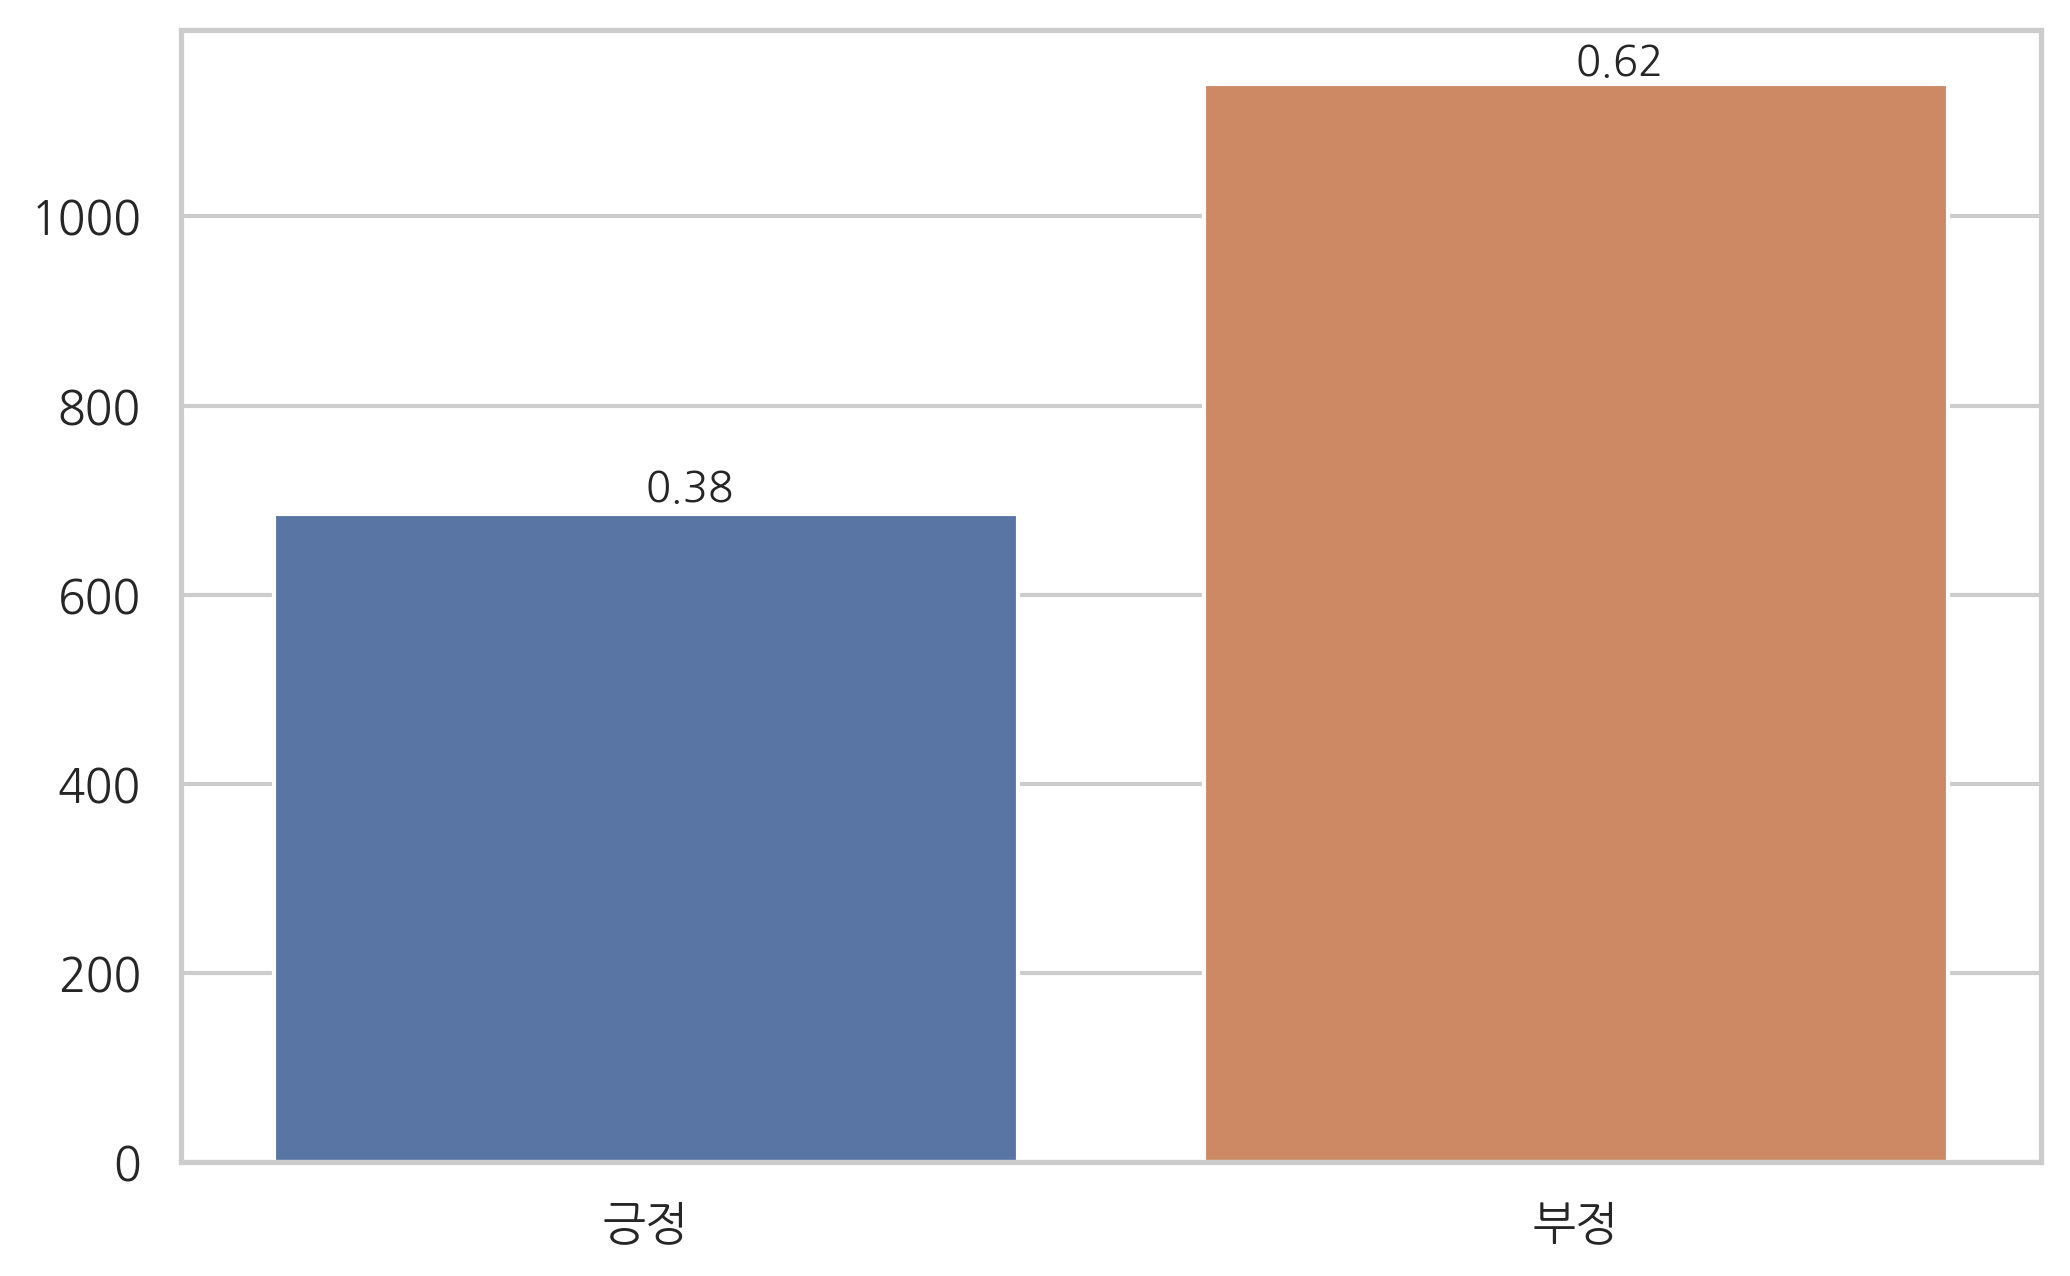

In [127]:
sns.barplot(x=['긍정','부정'], y=[len(positive_list), len(negative_list)])
plt.text(0,700, f'{round(len(positive_list)/len(cont),2)}')
plt.text(1,1150, f'{round(len(negative_list)/len(cont),2)}')

Text(0.5, 1.0, '감성분석 결과')

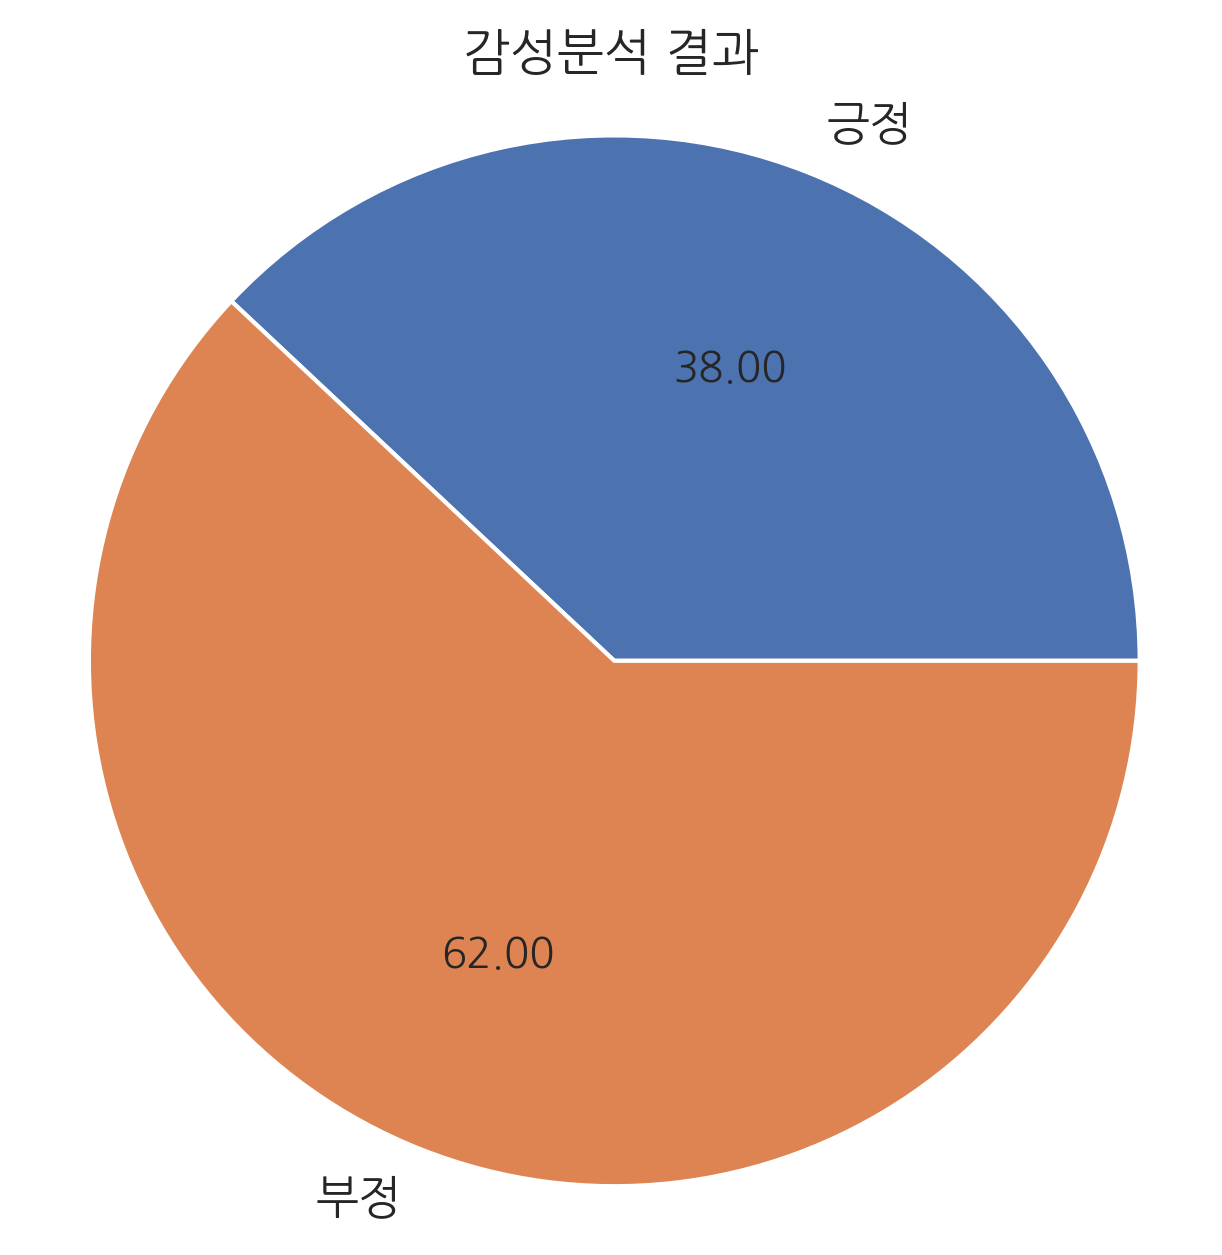

In [135]:
plt.figure(figsize=(5,5))
plt.pie([0.38, 0.62], autopct = '%1.2f', labels=['긍정', '부정'], )
plt.axis('equal')
plt.title('감성분석 결과')

## 전체 데이터셋에 학습된 모델 적용

In [16]:
df = pd.read_csv('/Users/kibeomkim/Desktop/유튜브 광고 데이터셋/50퍼센트 이상.csv') 
df.columns = ['삭제', '주소', '작성자', '작성일자', '내용', '공감수', '삭제2']
df = df.iloc[:, 1:6]

In [ ]:
nalchi = df[1:1826]
see_capture = df[1827:2041]
spen = df[2042:2111]
togo = df[2112:2231]
ultra = df[2232:2263]
memory = df[2264:2294]
unboxing = df[2295:3037]
jp_ep3 = df[3038:3347]
nalchi_unboxing = df[3348:3547]
panthom = df[3548:3571]
epic_in_everyway = df[3572:3579]
bang = df[3580:3597]
nobcut = df[3598:3695]
imperfect = df[3696:3724]

name_list = [nalchi, see_capture, spen, togo, ultra, memory, unboxing, jp_ep3, nalchi_unboxing, panthom, epic_in_everyway, bang, nobcut, imperfect]
names = ['nalchi', 'see_capture', 'spen', 'togo', 'ultra', 'memory', 'unboxing', 'jp_ep3', 'nalchi_unboxing', 'panthom', 'epic_in_everyway', 'bang', 'nobcut', 'imperfect']

p2 = sns.color_palette('colorblind', 10)
name_dict = dict()
no = 1
for name in name_list : 
    positive_list = []
    negative_list = []
    cont = list(name['내용'])
    
    for text in cont : 
        try : 
            new_input = text
            # 입력 데이터 형태소 분석하기 
            inputdata = []
            morphed_input = rhinoMorph.onlyMorph_list(rn, new_input, pos=['NNG', 'NNP', 'VV', 'VA', 'XR', 'IC', 'MM', 'MAG', 'MAJ'])
            morphed_input = ' '.join(morphed_input)                     # 한 개의 문자열로 만들기
            inputdata.append(morphed_input)                               # 분석 결과를 리스트로 만들기
            X_input = vect.transform(inputdata)
            result = grid.predict(X_input) # 0은 부정,1은 긍정

            if result[0] == '0' : 
                negative_list.append(result[0])
                #print("부정적인 글입니다")
            else:
                positive_list.append(result[0])
                #print("긍정적인 글입니다")
        except : 
            #print('댓글 이상')
            continue
    
    positive_num = len(positive_list)
    negative_num = len(negative_list)

    name_dict[no] = positive_num, negative_num
    
    sns.barplot(x=['긍정','부정'], y=[positive_num, negative_num], palette=p2)
    #plt.text(0,700, f'{round(positive_num/len(cont),2)}')
    #plt.text(1,1150, f'{round(negative_num/len(cont),2)}')
    plt.title(f'{names[no-1]}')

    f_dir = f'/Users/kibeomkim/Desktop/감성분석_결과'
    os.makedirs(f_dir+'/'+names[no-1])
    os.chdir(f_dir+'/'+names[no-1])
    plt.savefig(f'{no-1}.jpg', dpi=300)

    plt.pause(0.5)
    plt.close()

    #plt.figure(figsize=(5,5))
    plt.title(f'{names[no-1]}')
    plt.pie([round(positive_num/len(cont),2), round(negative_num/len(cont),2)], autopct = '%1.2f', labels=['긍정', '부정'], colors=['cyan', 'lightcoral'])
    #plt.axis('equal')

    plt.savefig(f'{no}.jpg', dpi=300)
    plt.pause(0.5)
    plt.close()

    no += 1


# 50% 이상인 그룹 - 감성분석 결과 정리 

In [237]:
pos_neg = pd.DataFrame(name_dict)
pos_neg.columns = ['nalchi', 'see_capture', 'spen', 'togo', 'ultra', 'memory', 'unboxing', 'jp_ep3', 'nalchi_unboxing', 'panthom', 'epic_in_everyway', 'bang', 'nobcut', 'imperfect']
pos_neg.index = ['긍정','부정']
pos_neg

,nalchi,see_capture,spen,togo,ultra,memory,unboxing,jp_ep3,nalchi_unboxing,panthom,epic_in_everyway,bang,nobcut,imperfect
긍정,685,86,31,35,10,12,431,175,83,15,3,6,41,15
부정,1140,128,38,84,21,18,309,132,116,8,4,11,56,13


# 50% 이하인 그룹 - 감성분석

In [19]:
df1 = pd.read_csv('/Users/kibeomkim/Desktop/유튜브 광고 데이터셋/50퍼센트 이하.csv') 
df1.columns = ['삭제', '주소', '작성자', '작성일자', '내용', '공감수', '삭제']
df1 = df1.iloc[1:, 1:6]

In [20]:
df1

,주소,작성자,작성일자,내용,공감수
1,"[갤럭시 s21] 한몸에 받다. 세상의 시선 / 조회수 : 2,449,304 / 광...",NaN,NaN,NaN,NaN
2,https://www.youtube.com/watch?v=bC9TksWbq-I,스트민,10 months ago,와 브금이랑 진짜 모든게 개간지나네,266
3,https://www.youtube.com/watch?v=bC9TksWbq-I,김보정,10 months ago,애플과 또다른 세련된 감성..,167
4,https://www.youtube.com/watch?v=bC9TksWbq-I,Daehwan Kim,10 months ago,깔끔하고 세련된 광고. 재드래곤 믿고 삼전갑니다.,166
5,https://www.youtube.com/watch?v=bC9TksWbq-I,김모죠,10 months ago,광고 진짜 많이 예뻐졌다,375
...,...,...,...,...,...
2310,https://www.youtube.com/watch?v=PbZxsRIOBBE&li...,주박 JBak,9 months ago,김 ㄹ 님 ㄷㄷ김 리을,2
2311,https://www.youtube.com/watch?v=PbZxsRIOBBE&li...,김철곤,17 hours ago,카메라부문 클리얼블랙으로. 버즈들도 클리어 한정판을주라디자인이라고뻥치는것보다 차라리...,0
2312,https://www.youtube.com/watch?v=PbZxsRIOBBE&li...,킹갓엠페럴제네럴황제충무공드래곤,8 months ago (edited),광고 브금 이름...제발,0
2313,https://www.youtube.com/watch?v=PbZxsRIOBBE&li...,ks,9 months ago,Z플립3 빨리 내주세여,0


In [ ]:
acceptview = df1[1:269]
erase = df1[271:301]
nowimreleased = df1[303:329]
yupeng_full = df1[331:787]
yupeng_ep2 = df1[789:1011]
yupeng_ep1 = df1[1013:1495]
zipcok_party = df1[1497:1597]
mydream = df1[1599:1630]
tongdong = df1[1632:1645]
bts_feature = df1[1647:1698]
bts_epic_8k = df1[1701:1857]
phonecasting = df1[1860:2085]
bts_night = df1[2087:2159]
son_commentary = df1[2161:2173]
son = df1[2175:2282]
designer = df1[2283:2314]


name_list = [acceptview, erase, nowimreleased, yupeng_full, yupeng_ep2, yupeng_ep1, zipcok_party, mydream, tongdong, bts_feature, bts_epic_8k, phonecasting, bts_night, son_commentary, son, designer]
names = ['acceptview', 'erase', 'nowimreleased', 'yupeng_full', 'yupeng_ep2', 'yupeng_ep1', 'zipcok_party', 'mydream', 'tongdong', 'bts_feature', 'bts_epic_8k', 'phonecasting', 'bts_night', 'son_commentary', 'son', 'designer']

p2 = sns.color_palette('colorblind', 10)
name_dict = dict()
no = 1
for name in name_list : 
    positive_list = []
    negative_list = []
    cont = list(name['내용'])
    
    for text in cont : 
        try : 
            new_input = text
            # 입력 데이터 형태소 분석하기 
            inputdata = []
            morphed_input = rhinoMorph.onlyMorph_list(rn, new_input, pos=['NNG', 'NNP', 'VV', 'VA', 'XR', 'IC', 'MM', 'MAG', 'MAJ'])
            morphed_input = ' '.join(morphed_input)                     # 한 개의 문자열로 만들기
            inputdata.append(morphed_input)                               # 분석 결과를 리스트로 만들기
            X_input = vect.transform(inputdata)
            result = grid.predict(X_input) # 0은 부정,1은 긍정

            if result[0] == '0' : 
                negative_list.append(result[0])
                #print("부정적인 글입니다")
            else:
                positive_list.append(result[0])
                #print("긍정적인 글입니다")
        except : 
            #print('댓글 이상')
            continue
    
    positive_num = len(positive_list)
    negative_num = len(negative_list)

    name_dict[no] = positive_num, negative_num
    
    sns.barplot(x=['긍정','부정'], y=[positive_num, negative_num], palette=p2)
    #plt.text(0,700, f'{round(positive_num/len(cont),2)}')
    #plt.text(1,1150, f'{round(negative_num/len(cont),2)}')
    plt.title(f'{names[no-1]}')

    f_dir = f'/Users/kibeomkim/Desktop/50%이하_감성분석 결과'
    os.makedirs(f_dir+'/'+names[no-1])
    os.chdir(f_dir+'/'+names[no-1])
    plt.savefig(f'{no-1}.jpg', dpi=300)

    plt.pause(0.5)
    plt.close()

    #plt.figure(figsize=(5,5))
    plt.title(f'{names[no-1]}')
    plt.pie([round(positive_num/len(cont),2), round(negative_num/len(cont),2)], autopct = '%1.2f', labels=['긍정', '부정'], colors=['cyan', 'lightcoral'])
    #plt.axis('equal')

    plt.savefig(f'{no}.jpg', dpi=300)
    plt.pause(0.5)
    plt.close()

    no += 1


# 50% 이하인 그룹_감성분석 결과 정리 

In [24]:
pos_neg = pd.DataFrame(name_dict)
pos_neg.columns = ['acceptview', 'erase', 'nowimreleased', 'yupeng_full', 'yupeng_ep2', 'yupeng_ep1', 'zipcok_party', 'mydream', 'tongdong', 'bts_feature', 'bts_epic_8k', 'phonecasting', 'bts_night', 'son_commentary', 'son', 'designer']
pos_neg.index = ['긍정','부정']
pos_neg

,acceptview,erase,nowimreleased,yupeng_full,yupeng_ep2,yupeng_ep1,zipcok_party,mydream,tongdong,bts_feature,bts_epic_8k,phonecasting,bts_night,son_commentary,son,designer
긍정,124,14,10,234,119,263,35,16,5,20,76,118,34,6,62,20
부정,144,16,16,218,103,217,65,15,7,31,80,107,38,6,44,11


In [33]:
for i in range(len(list(acceptview['내용']))) : 
    new_input = list(acceptview['내용'])[i]
    # 입력 데이터 형태소 분석하기 
    inputdata = []
    morphed_input = rhinoMorph.onlyMorph_list(rn, new_input, pos=['NNG', 'NNP', 'VV', 'VA', 'XR', 'IC', 'MM', 'MAG', 'MAJ'])
    morphed_input = ' '.join(morphed_input)                     # 한 개의 문자열로 만들기
    inputdata.append(morphed_input)                               # 분석 결과를 리스트로 만들기
    X_input = vect.transform(inputdata)
    result = grid.predict(X_input) # 0은 부정,1은 긍정

    if result[0] == '0' : 
        print(new_input)
        print("부정적인 글입니다")
    else:
        pass
    print('\n')








광고 진짜 많이 예뻐졌다
부정적인 글입니다








S21+ 바이올렛 잘뽑았더라
부정적인 글입니다




갓성이다.. 이제 광고도 잘 찍고,삼성 성능 좋은건 다들 알고 있는거구,디자인은...s20보단 낫다..💕
부정적인 글입니다


이광고 해외수출좀..  제발
부정적인 글입니다










O comercial tá bem melhor que o ocidental.
부정적인 글입니다












ㄹㅇ디자인최고❤️
부정적인 글입니다


와 광고 잘뽑았다.. 제발 좀 앞으로 이렇게 뽑길
부정적인 글입니다


이런 멋진 광고는 도대체 어떻게 아이디어를 얻을까?
부정적인 글입니다








건물 기울기직전에 앵글 멋있네 ㅋㅋ
부정적인 글입니다


고조 되다 퐉 터지면서 카메라 앵글을 진짜 잘 잡는다
부정적인 글입니다
















파운드리 스마트반도체 도약하자 21년 반도체   사이클의 도래 하닉도 물론 잘가면 좋겠다 메모리반도체도 교체주기가 됬다
부정적인 글입니다








방금 텔레비에서 보고 검색해서 찾아봄 광고 잘만들었다
부정적인 글입니다


S21 나오자마자 FE 사버리기~
부정적인 글입니다




Samsung Korea in Apple에서 iPhone Pro 2021의 120Hz 화면 새로 고침은 자동으로 10Hz에서 120Hz이며 자동이므로 제거하지 않고 덜 조정합니다 (응용 프로그램에 존재하지 않음) 이것은 삼성과 다른 브랜드의 Android 경쟁에서 동일하게 모바일 배터리가 훨씬 더 오래 지속되는 경우입니다.
부정적인 글입니다








난 아이폰 12광고보다 이게 더 나음
부정적인 글입니다




개인적으로 갤럭시 s10 배 나오는 광고가 제일 잘 뽑은거 같아요
부정적인 글입니다




아이폰12가 출시 두 달만에 삼성 1년치 5G폰 판매량을 추월했다는게 그저 신기할뿐... 이번 s21으로 다시 자리잡길....
부정적인 글입니다










Samsung in the Samsung Wha

In [29]:
negative_list

['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']